## Question 2

In [ ]:
!nvidia-smi

Thu May  5 13:53:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |  13056MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install wandb

     |████████████████████████████████| 1.8 MB 30.4 MB/s 
     |████████████████████████████████| 144 kB 67.8 MB/s 
     |████████████████████████████████| 181 kB 69.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=44753b9724c6160a3a6445278dfe5d9e468c0af216dd70f4eaf5fc65946ef09b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torch.autograd import Variable
import wandb
import copy
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import seaborn as sns
import time

In [ ]:
gpu_is_av = torch.cuda.is_available()
print(gpu_is_av)

True


In [ ]:
#import the Fashion MNIST dataset
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

train_dwn = datasets.FashionMNIST('fashion-mnist_train', train=True, download=True, transform=transform)
train_len = int(0.8*len(train_dwn))
train_data, val_data = random_split(train_dwn, [train_len, len(train_dwn)-train_len])
train_data = DataLoader(train_data, batch_size=100, shuffle=True)
val_data = DataLoader(val_data, batch_size=100, shuffle=True)

test_dwn = datasets.FashionMNIST('fashion-mnist_test', train=False, download=True, transform=transform)
test_data = DataLoader(test_dwn, batch_size=100, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion-mnist_train/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-mnist_train/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion-mnist_train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-mnist_train/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion-mnist_train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-mnist_train/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion-mnist_train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-mnist_train/FashionMNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion-mnist_test/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-mnist_test/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion-mnist_test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-mnist_test/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion-mnist_test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-mnist_test/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion-mnist_test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-mnist_test/FashionMNIST/raw



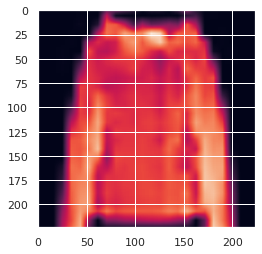

In [ ]:
%matplotlib inline

#get training samples and labels
train_samples, train_labels = next(iter(train_data))
val_samples, val_labels = next(iter(val_data))
test_samples, test_labels = next(iter(test_data))

#visualuse an image from the fashion mnist dataset
seaborn.set()
if(train_samples[0].shape[0]==3):
    img = train_samples[0][0,:,:]
    plt.imshow(img)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#checkout exisiting layers
print("Output Features:", model.classifier[6].out_features)
print(model)

Output Features: 1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
#freeze weights of the lower convolutional layers
for wt in model.features.parameters():
    wt.requires_grad = False

#find number of classes for our dataset
num_classes = len(np.unique(train_labels))
model.class_to_idx = train_dwn.class_to_idx
print(model.class_to_idx)
print(num_classes)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
10


In [ ]:
#remove the last layer and add a new one with 10 output classes
last_layer_in = model.classifier[6].in_features
pre_layers = list(model.classifier.children())[:-1]
pre_layers.extend([torch.nn.Linear(last_layer_in, num_classes)])
model.classifier = torch.nn.Sequential(*pre_layers)
if gpu_is_av:
  model.cuda()

In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(sync_tensorboard=True)

wandb: Currently logged in as: meetakshisetiya. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(name="vgg16_q2", 
            project="ML_A2", 
            tags=["vgg16", "fashion_mnist", "ML_A2"], 
            entity="meetakshisetiya"
    )

In [ ]:
def train_vgg(model, loss_function, optimizer, epochs=10):
    best_model = copy.deepcopy(model)
    average_train_loss = 0
    average_train_accuracy = 0
    average_validation_loss = 0
    average_validation_accuracy = 0
    max_accuracy = 0

    for epoch in tqdm(range(epochs)):

        #put model in train mode
        model.train(True)
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        print("\n\n----------- Epoch:", epoch+1, "of", epochs, "-----------")
        #train samples and train labels
        for i, (samples, labels) in enumerate(train_data):
            if gpu_is_av:
              samples, classes = Variable(samples.cuda()), Variable(labels.cuda())
            else:
              samples, classes = Variable(samples), Variable(labels)
            #zero the gradients
            optimizer.zero_grad() 
            #forward pass
            op = model(samples)
            #calculate loss
            loss = loss_function(op, classes)
            #back propagation
            loss.backward()
            #update weights
            optimizer.step()
            #calculate accuracy
            accuracy = torch.sum(torch.argmax(op, dim=1) == classes).item()/len(classes)
            train_loss += loss.item()
            train_accuracy += accuracy
            #print("Training Batch:", i, " Training Loss:", loss.item(), "Training Accuracy:", accuracy)
            del samples, classes, op
            torch.cuda.empty_cache()
        
        #put model in eval mode
        model.train(False)
        model.eval()
        #validation samples and validation labels
        for i, (samples, labels) in enumerate(val_data):
            #print("Validation Batch:", i)
            if gpu_is_av:
              samples, classes = Variable(samples.cuda()), Variable(labels.cuda())
            else:
              samples, classes = Variable(samples), Variable(labels)
            #zero the gradients
            optimizer.zero_grad()
            # #forward pass
            val_op = model(samples)
            #find loss
            vloss = loss_function(val_op, classes)
            #calculate accuracy
            vaccuracy = torch.sum(torch.argmax(val_op, dim=1) == classes).item()/len(classes)
            val_loss += vloss.item() 
            val_accuracy += vaccuracy
            #print("Validation Loss:", vloss.item(), "Validation Accuracy:", vaccuracy)
            del samples, classes, val_op
            torch.cuda.empty_cache()

        #calculate average loss and accuracy
        average_train_loss = train_loss/len(train_data)
        average_validation_loss = val_loss/len(val_data)
        average_train_accuracy = train_accuracy/len(train_data)
        average_validation_accuracy = val_accuracy/len(val_data)
        print("Average training loss: {:.5f} | Average training accuracy: {:.5f}".format(average_train_loss, average_train_accuracy))
        print("Average validation loss: {:.5f} | Average validation accuracy: {:.5f}".format(average_validation_loss, average_validation_accuracy))
        print()

        #update best model
        if(average_validation_accuracy > max_accuracy):
            max_accuracy = average_validation_accuracy
            best_model = copy.deepcopy(model.state_dict())

        wandb.log({
            "epoch": epoch,
            "train_loss": average_train_loss,
            "train_accuracy": average_train_accuracy,
            "val_loss": average_validation_loss,
            "val_accuracy": average_validation_accuracy,
            })
            
    print("\nTraining Complete")
    print("Best Validation Accuracy:", max_accuracy)
    return best_model

In [ ]:
def evaluate_vgg(model, loss_function):
    average_test_loss = 0
    average_test_accuracy = 0 
    test_loss = 0
    test_accuracy = 0
    if gpu_is_av:
      device = "cuda"
    else:
      device = "cpu"
    y_pred = torch.zeros(0, dtype=torch.long, device=device)
    y_labels = torch.zeros(0, dtype=torch.long, device=device)
    print("\n----------- Testing Results for VGG16 -----------")
    #put model in eval mode
    model.train(False)
    model.eval()
    for i, (samples, labels) in enumerate(test_data):
        print("Test Batch:", i)
        if gpu_is_av:
            samples, classes = Variable(samples.cuda()), Variable(labels.cuda())
        else:
            samples, classes = Variable(samples), Variable(labels)
        test_op = model(samples)
        #find loss
        tloss = loss_function(test_op, classes)
        #calculate accuracy
        preds = torch.argmax(test_op, dim=1)
        taccuracy = torch.sum(preds == classes).item()/len(classes)
        test_loss += tloss.item()
        test_accuracy += taccuracy
        print("Test Loss:", tloss.item(), "Test Accuracy:", taccuracy)

        if gpu_is_av:
          y_pred = torch.cat([y_pred, preds.view(-1).cuda()])
          y_labels = torch.cat([y_labels, labels.view(-1).cuda()])
        else:
          y_pred = torch.cat([y_pred, preds.view(-1).cpu()])
          y_labels = torch.cat([y_labels, labels.view(-1).cpu()])
        
    #calculate average loss and accuracy
    average_test_loss = test_loss/len(test_data)
    average_test_accuracy = test_accuracy/len(test_data)
    print("Average Test Loss:", average_test_loss)
    print("Average Test Accuracy:", average_test_accuracy)

    return average_test_loss, average_test_accuracy, y_pred, y_labels


In [ ]:
torch.cuda.empty_cache()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_vgg(model, torch.nn.CrossEntropyLoss(), optimizer, epochs=10)

In [ ]:
optimizer2 = torch.optim.Adam(model.parameters())
best_model = train_vgg(model, torch.nn.CrossEntropyLoss(), optimizer2, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]



----------- Epoch: 1 of 10 -----------


 10%|█         | 1/10 [08:19<1:14:58, 499.78s/it]

Average training loss: 0.37439 | Average training accuracy: 0.90144
Average validation loss: 0.27291 | Average nvalidatio accuracy: 0.91325



----------- Epoch: 2 of 10 -----------


 20%|██        | 2/10 [16:00<1:03:33, 476.73s/it]

Average training loss: 0.30557 | Average training accuracy: 0.91190
Average validation loss: 0.26742 | Average nvalidatio accuracy: 0.91475



----------- Epoch: 3 of 10 -----------


 30%|███       | 3/10 [24:26<57:09, 489.98s/it]  

Average training loss: 0.25984 | Average training accuracy: 0.92433
Average validation loss: 0.26283 | Average nvalidatio accuracy: 0.91783



----------- Epoch: 4 of 10 -----------


 40%|████      | 4/10 [32:04<47:45, 477.64s/it]

Average training loss: 0.25215 | Average training accuracy: 0.92883
Average validation loss: 0.28373 | Average nvalidatio accuracy: 0.91283



----------- Epoch: 5 of 10 -----------


 50%|█████     | 5/10 [39:44<39:16, 471.32s/it]

Average training loss: 0.20651 | Average training accuracy: 0.93983
Average validation loss: 0.26564 | Average nvalidatio accuracy: 0.92092



----------- Epoch: 6 of 10 -----------


 60%|██████    | 6/10 [48:13<32:16, 484.04s/it]

Average training loss: 0.20503 | Average training accuracy: 0.94333
Average validation loss: 0.27840 | Average nvalidatio accuracy: 0.92308



----------- Epoch: 7 of 10 -----------


 70%|███████   | 7/10 [55:53<23:48, 476.10s/it]

Average training loss: 0.17501 | Average training accuracy: 0.94879
Average validation loss: 0.29187 | Average nvalidatio accuracy: 0.92642



----------- Epoch: 8 of 10 -----------


 80%|████████  | 8/10 [1:04:27<16:16, 488.04s/it]

Average training loss: 0.17170 | Average training accuracy: 0.95169
Average validation loss: 0.27313 | Average nvalidatio accuracy: 0.92450



----------- Epoch: 9 of 10 -----------


 90%|█████████ | 9/10 [1:13:11<08:19, 499.32s/it]

Average training loss: 0.15783 | Average training accuracy: 0.95517
Average validation loss: 0.26140 | Average nvalidatio accuracy: 0.92967



----------- Epoch: 10 of 10 -----------


100%|██████████| 10/10 [1:20:54<00:00, 485.46s/it]

Average training loss: 0.15214 | Average training accuracy: 0.95692
Average validation loss: 0.27375 | Average nvalidatio accuracy: 0.92417


Training Complete
Best Validation Accuracy: 0.9296666666666671


In [ ]:
average_test_loss, average_test_accuracy, y_pred, y_labels = evaluate_vgg(model, torch.nn.CrossEntropyLoss())


----------- Testing Results for VGG16 -----------
Average Test Loss: 0.2954158514738083
Average Test Accuracy: 0.9164000000000005


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/vgg_trained2.pkl")

Confusion Matrix:


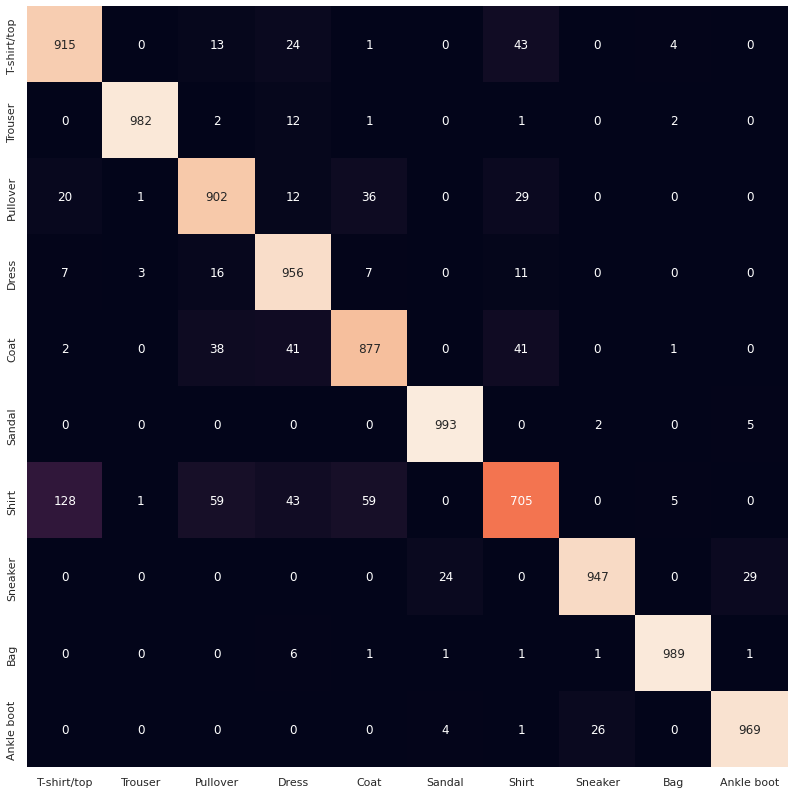

In [ ]:
sns.set_theme()
conf_matrix = confusion_matrix(y_labels.cpu().numpy() , y_pred.cpu().numpy(), labels=np.linspace(0,9,10))
plt.figure(figsize=(14,14))
sns.heatmap(conf_matrix, square=True, annot=True, cmap='rocket', fmt='d', cbar=False, xticklabels=model.class_to_idx.keys(), yticklabels=model.class_to_idx.keys())
print("Confusion Matrix:")
plt.grid(False)
plt.show()

In [ ]:
model.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [ ]:
print("Class-wise Accuracies: ")
classwise_acc = 100*conf_matrix.diagonal()/conf_matrix.sum(1)
for i in model.class_to_idx:
  index = model.class_to_idx[i]
  print("Accuracy for class", i, ":", classwise_acc[index], "%")

Class-wise Accuracies: 
Accuracy for class T-shirt/top : 91.5 %
Accuracy for class Trouser : 98.2 %
Accuracy for class Pullover : 90.2 %
Accuracy for class Dress : 95.6 %
Accuracy for class Coat : 87.7 %
Accuracy for class Sandal : 99.3 %
Accuracy for class Shirt : 70.5 %
Accuracy for class Sneaker : 94.7 %
Accuracy for class Bag : 98.9 %
Accuracy for class Ankle boot : 96.9 %


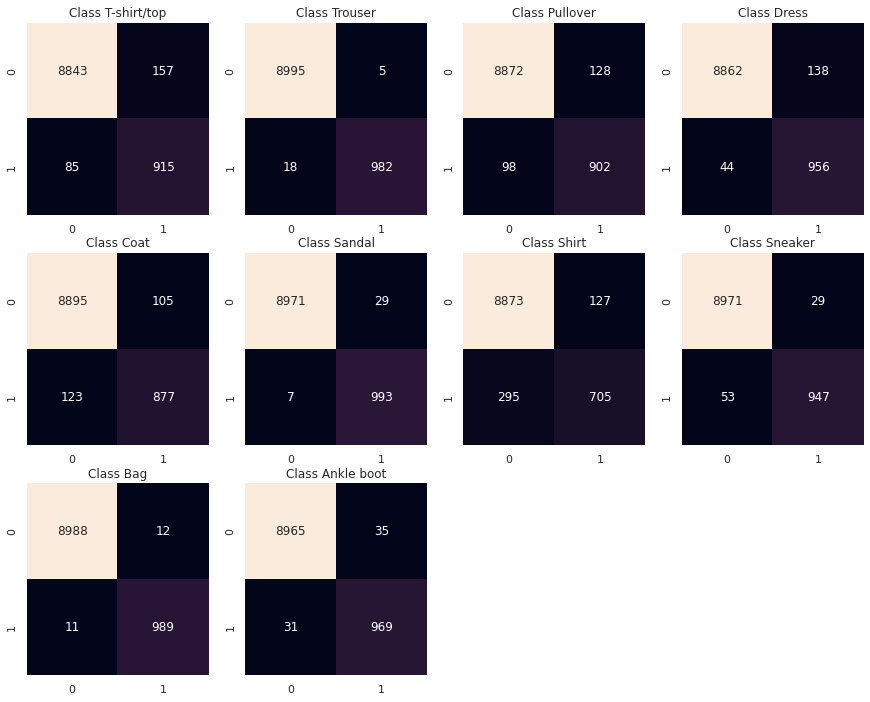

In [ ]:
mul_conf_matrix = multilabel_confusion_matrix(y_labels.cpu().numpy(), y_pred.cpu().numpy(), labels=list(range(10)))
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i in range(10):
  sns.heatmap(mul_conf_matrix[i], annot=True, fmt="d", ax=axes[i//4, i%4], cbar=False, cmap="rocket")
  axes[i//4, i%4].set_title(f"Class {list(model.class_to_idx.keys())[i]}")
fig.delaxes(axes[2,2])
fig.delaxes(axes[2,3])
plt.show()